In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import time
import random
import copy

In [111]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [112]:
# List of environments
list(gym.envs.registry.keys())

['CartPole-v0',
 'CartPole-v1',
 'MountainCar-v0',
 'MountainCarContinuous-v0',
 'Pendulum-v1',
 'Acrobot-v1',
 'phys2d/CartPole-v0',
 'phys2d/CartPole-v1',
 'phys2d/Pendulum-v0',
 'LunarLander-v3',
 'LunarLanderContinuous-v3',
 'BipedalWalker-v3',
 'BipedalWalkerHardcore-v3',
 'CarRacing-v3',
 'Blackjack-v1',
 'FrozenLake-v1',
 'FrozenLake8x8-v1',
 'CliffWalking-v0',
 'Taxi-v3',
 'tabular/Blackjack-v0',
 'tabular/CliffWalking-v0',
 'Reacher-v2',
 'Reacher-v4',
 'Reacher-v5',
 'Pusher-v2',
 'Pusher-v4',
 'Pusher-v5',
 'InvertedPendulum-v2',
 'InvertedPendulum-v4',
 'InvertedPendulum-v5',
 'InvertedDoublePendulum-v2',
 'InvertedDoublePendulum-v4',
 'InvertedDoublePendulum-v5',
 'HalfCheetah-v2',
 'HalfCheetah-v3',
 'HalfCheetah-v4',
 'HalfCheetah-v5',
 'Hopper-v2',
 'Hopper-v3',
 'Hopper-v4',
 'Hopper-v5',
 'Swimmer-v2',
 'Swimmer-v3',
 'Swimmer-v4',
 'Swimmer-v5',
 'Walker2d-v2',
 'Walker2d-v3',
 'Walker2d-v4',
 'Walker2d-v5',
 'Ant-v2',
 'Ant-v3',
 'Ant-v4',
 'Ant-v5',
 'Humanoid-v2',

In [113]:
import gymnasium as gym

env = gym.make('CartPole-v1', render_mode='human')
env.reset(seed=42)

try:
    for i in range(100):
        env.render()
        # time.sleep(0.1)
        action = env.action_space.sample()  
        observation, reward, terminated, truncated, info = env.step(action)
        print(i, observation, reward, terminated, truncated, info)
        if terminated:
            break
finally:
    # Always close the environment after use to avoid unresponsiveness
    env.close()


0 [ 0.02727336 -0.20172954  0.03625453  0.32351476] 1.0 False False {}
1 [ 0.02323877 -0.00714208  0.04272482  0.04248186] 1.0 False False {}
2 [ 0.02309593 -0.20284982  0.04357446  0.34833285] 1.0 False False {}
3 [ 0.01903893 -0.39856356  0.05054112  0.65443164] 1.0 False False {}
4 [ 0.01106766 -0.5943515   0.06362975  0.96259123] 1.0 False False {}
5 [-8.1936747e-04 -7.9026806e-01  8.2881577e-02  1.2745659e+00] 1.0 False False {}
6 [-0.01662473 -0.59629536  0.1083729   1.008945  ] 1.0 False False {}
7 [-0.02855064 -0.7926839   0.1285518   1.3335989 ] 1.0 False False {}
8 [-0.04440431 -0.5993953   0.15522377  1.0837486 ] 1.0 False False {}
9 [-0.05639222 -0.40662387  0.17689875  0.84352076] 1.0 False False {}
10 [-0.0645247  -0.21429996  0.19376916  0.6112743 ] 1.0 False False {}
11 [-0.06881069 -0.02233852  0.20599464  0.38533318] 1.0 False False {}
12 [-0.06925747  0.16935486  0.21370131  0.1640073 ] 1.0 True False {}


In [114]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
# env = gym.wrappers.RecordVideo(env, video_folder="Cartpole Training Videos", name_prefix="train-video", episode_trigger=lambda e: e % 100 == 0)  # Record every 100 episodes

INITIALIZE NETWORKS

In [116]:
input_dim = env.observation_space.shape[0] #4
output_dim = env.action_space.n #2
print(input_dim,output_dim)

4 2


In [117]:
Q_net = nn.Sequential(
                nn.Linear(input_dim,64),
                nn.ReLU(),
                nn.Linear(64,64),
                nn.ReLU(),
                nn.Linear(64,output_dim)
)   

In [118]:
target_net = copy.deepcopy(Q_net)

FUNCTION TO UPDATE TARGET NET

In [119]:
def update_target_net(q_network, target_network, tau):
    for target_param, q_param in zip(target_network.parameters(), q_network.parameters()):
        target_param.data.copy_(tau * q_param.data + (1.0 - tau) * target_param.data)

REPLAY BUFFER TO STORE EXPERIENCES

In [120]:
buffer_size = 10000
replay_buffer = []
buffer_counter = 0

In [121]:
def push_memory(state, action, reward, next_state, done):
    buffer_size = 10000
    global buffer_counter
    if buffer_counter < buffer_size:
        replay_buffer.append((state, action, reward, next_state, done))

    else:
        replay_buffer[buffer_counter % buffer_size] = (state, action, reward, next_state, done)

    buffer_counter += 1

In [122]:
def sample_batch(batch_size):
    return random.sample(replay_buffer, batch_size)

FUNCTION TO SELECT ACTION

In [123]:
def select_action(state, q_network, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()  # Random action
    else:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # We need the input dimension to be [batch_size,input_layer_size]
        with torch.no_grad():
            q_values = q_network(state_tensor)
        return torch.argmax(q_values).item()

DEFINE HYPERPARAMETERS

In [124]:
learning_rate = 0.0001
gamma = 0.9
epsilon = 1.0
epsilon_decay = 0.995
min_epsilon = 0.0001
batch_size = 64
num_episodes = 1200
tau = 0.01

TRAINING LOOP

In [125]:
optimizer = optim.Adam(Q_net.parameters(), lr=learning_rate)
loss_func = nn.MSELoss()

In [126]:
episodewise_reward = [0]*num_episodes

In [127]:
for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0
    step_counter = 0
    
    while not done:
        # Select action
        action = select_action(state, Q_net, epsilon)
        
        # Take action in environment
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        episodewise_reward[episode]+=reward
        
        # Store experiences in replay buffer
        push_memory(state, action, reward, next_state, done)
        
        # Sample a batch from the memory/buffer
        if len(replay_buffer) >= batch_size:
            batch = sample_batch(batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)
            
            states_tensor = torch.tensor(states, dtype=torch.float32)
            actions_tensor = torch.tensor(actions, dtype=torch.long)
            rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
            next_states_tensor = torch.tensor(next_states, dtype=torch.float32)
            dones_tensor = torch.tensor(dones, dtype=torch.float32)
            
            # Compute Q-values from Q network and Target Network
            q_values = Q_net(states_tensor)
            next_q_values = target_net(next_states_tensor)
            
            # Compute the target Q-value
            next_q_value = next_q_values.max(dim=1)[0]
            target_q_value = rewards_tensor + (gamma * next_q_value * (1 - dones_tensor))
            
            # Compute the MSE loss
            q_value = q_values.gather(1, actions_tensor.unsqueeze(1)).squeeze(1)
            loss = loss_func(q_value, target_q_value)
            
            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #Update the step counter
            step_counter+=1
        
        # Update the state
        state = next_state
    
    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    
    # Softly update the target network
    update_target_net(Q_net, target_net, tau)
    
    env.render()
    
    # Print progress
    if episode % 50 == 0:
        print(f"Episode {episode+1}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}, teminated afer {step_counter} steps.")

env.close()

Episode 1, Total Reward: 30.0, Epsilon: 0.995, teminated afer 0 steps.
Episode 51, Total Reward: 10.0, Epsilon: 0.774, teminated afer 10 steps.
Episode 101, Total Reward: 12.0, Epsilon: 0.603, teminated afer 12 steps.
Episode 151, Total Reward: 9.0, Epsilon: 0.469, teminated afer 9 steps.
Episode 201, Total Reward: 14.0, Epsilon: 0.365, teminated afer 14 steps.
Episode 251, Total Reward: 14.0, Epsilon: 0.284, teminated afer 14 steps.
Episode 301, Total Reward: 10.0, Epsilon: 0.221, teminated afer 10 steps.
Episode 351, Total Reward: 15.0, Epsilon: 0.172, teminated afer 15 steps.
Episode 401, Total Reward: 25.0, Epsilon: 0.134, teminated afer 25 steps.
Episode 451, Total Reward: 129.0, Epsilon: 0.104, teminated afer 129 steps.
Episode 501, Total Reward: 130.0, Epsilon: 0.081, teminated afer 130 steps.
Episode 551, Total Reward: 164.0, Epsilon: 0.063, teminated afer 164 steps.
Episode 601, Total Reward: 152.0, Epsilon: 0.049, teminated afer 152 steps.
Episode 651, Total Reward: 157.0, Ep

PLOT EPISODE VS REWARD PLOT

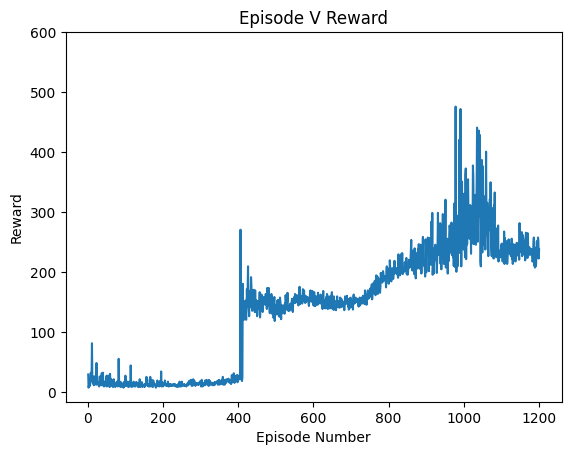

In [128]:
x = [i+1 for i in range(num_episodes)]
y = episodewise_reward
plt.plot(x,y)
plt.xlabel("Episode Number")
plt.ylabel("Reward")
plt.title("Episode V Reward")
plt.yticks([0,100,200,300,400,500,600])
plt.savefig('reward_plot.png', dpi=300)
plt.show()

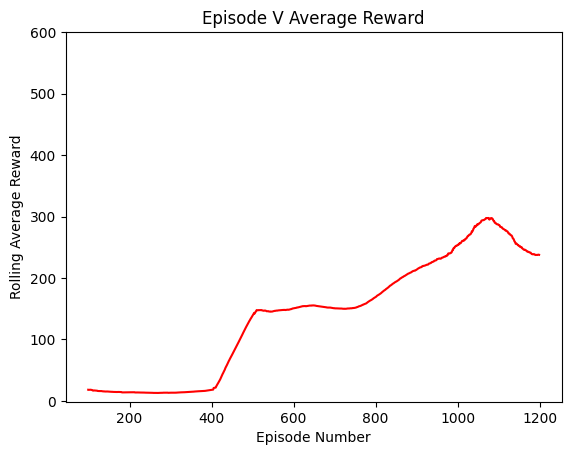

In [129]:
pd.Series(episodewise_reward).rolling(100).mean().plot(color='red')
plt.xlabel('Episode Number')
plt.ylabel('Rolling Average Reward')
plt.title('Episode V Average Reward')
plt.yticks([0,100,200,300,400,500,600])
plt.savefig('rolling_average_reward_plot.png', dpi=300)
plt.show()

AFTER TRAINING THE AGENT

In [132]:
env = gym.make('CartPole-v1', render_mode='human')
state , _ = env.reset()

try:
    for i in range(500):
        env.render()
        # time.sleep(0.1)
        with torch.no_grad():
            q_values = Q_net(torch.tensor(state, dtype=torch.float32))
        action = torch.argmax(q_values).item()
        observation, reward, terminated, truncated, info = env.step(action)
        print(i, observation, reward, terminated, truncated, info)
        state = observation
        if terminated:
            break
finally:
    # Always close the environment after use to avoid unresponsiveness
    env.close()

0 [-0.00546628 -0.17209007  0.00552926  0.2964793 ] 1.0 False False {}
1 [-0.00890809 -0.3672904   0.01145884  0.5909009 ] 1.0 False False {}
2 [-0.01625389 -0.17233075  0.02327686  0.30184945] 1.0 False False {}
3 [-0.01970051 -0.36777657  0.02931385  0.6017816 ] 1.0 False False {}
4 [-0.02705604 -0.17307667  0.04134948  0.31847423] 1.0 False False {}
5 [-0.03051757 -0.3687624   0.04771896  0.6239052 ] 1.0 False False {}
6 [-0.03789282 -0.17433803  0.06019707  0.34662467] 1.0 False False {}
7 [-0.04137958 -0.37026227  0.06712956  0.65766597] 1.0 False False {}
8 [-0.04878483 -0.17613578  0.08028288  0.38685337] 1.0 False False {}
9 [-0.05230754  0.0177602   0.08801995  0.120524  ] 1.0 False False {}
10 [-0.05195234  0.21151802  0.09043043 -0.14314312] 1.0 False False {}
11 [-0.04772198  0.40523633  0.08756757 -0.40598294] 1.0 False False {}
12 [-0.03961725  0.59901446  0.07944791 -0.6698245 ] 1.0 False False {}
13 [-0.02763696  0.7929472   0.06605142 -0.9364728 ] 1.0 False False {}
14